## Yoni Levine and Farhad Zmarai
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from readability import Readability
import spacy
from tqdm.notebook import tqdm
tqdm.pandas(desc='progress-bar')

import multiprocessing
cores = multiprocessing.cpu_count()
from ipywidgets import FloatProgress
pd.set_option("display.max_columns", None)
from collections import Counter
import string

from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
import re

In [2]:
depression = pd.read_csv('https://www.dropbox.com/s/dsxdhwztitydwdg/depression_raw.csv?dl=1')
suicide = pd.read_csv('https://www.dropbox.com/s/ilphpbm9mrrro2o/suicide_raw.csv?dl=1')

# Depression Data Exploration

In [3]:
depression.head()

,username,text,posts,url,date_posted
0,ayoubalharchal,\n\n\nDo you ever feel like everyone is watchi...,8,https://www.takethislife.com/depression/do-you...,"07-19-22, 02:47 PM"
1,ayoubalharchal,\n\n\nDo you compare yourself to other people ...,8,https://www.takethislife.com/depression/do-you...,"07-14-22, 05:15 PM"
2,ayoubalharchal,\n\n\nDo you find yourself apologizing all the...,8,https://www.takethislife.com/depression/do-you...,"07-14-22, 08:34 AM"
3,ayoubalharchal,"\n\n\nIF SO, READING & UNDERSTANDING THIS WILL...",8,https://www.takethislife.com/depression/do-you...,"07-12-22, 05:00 PM"
4,ayoubalharchal,\n\n\nAren’t you a little bit tired of people ...,8,https://www.takethislife.com/depression/aren-t...,"07-12-22, 07:56 AM"


In [4]:
depression.dtypes

username       object
text           object
posts           int64
url            object
date_posted    object
dtype: object

In [5]:
depression.describe()
# The numbers are highly skewed as the users with the most posts appear the most frequently in the data frame. 
# Will manually calculate the mean and median posts per user

,posts
count,19328.000000
mean,1230.330608
std,2691.801545
min,0.000000
25%,8.000000
50%,87.000000
75%,939.000000
max,18210.000000


In [6]:
user_post_count = pd.DataFrame(depression.groupby('username')['posts'].max()).sort_values('posts')
user_post_count

,posts
username,
JustBreathe,0
mr201,1
UK20101982,1
HelpMeNowPlease,1
HelpMe22,1
...,...
irishred,11944
Blue Girl,13622
Road Ratt,13622


In [7]:
mean = np.mean(user_post_count['posts'])
median = np.median(user_post_count['posts'])
print(f"The average number of posts per user is {mean} and the median is {median}.")

The average number of posts per user is 105.58227323008849 and the median is 4.0.


In [8]:
depression.isna().sum()
#username was actually "nan" 

username       1
text           0
posts          0
url            0
date_posted    0
dtype: int64

In [9]:
#standardizing usernames
depression['username_clean'] = [str(d).lower().replace(' ','_') for d in depression['username']]
depression['posts'] = pd.to_numeric(depression['posts'])
depression['date_posted'] = [datetime.datetime.strptime(d, '%m-%d-%y, %H:%M %p').date() for d in depression['date_posted']]

In [10]:
depression.shape

(19328, 6)

In [11]:
#remove posts with less than 30 chars
depression = depression[depression['text'].apply(lambda x: len(str(x))>=30)]
#remove users for which posts showed up as 0
depression = depression[depression['posts']>=1]
#remove posts which users posted twice (different url so not dropped with regular dedupe)
depression = depression.drop_duplicates(subset=['text','username_clean'])

# Creating features from text

In [12]:
#building some shallow features from the posts
depression['post_length'] = [len(post) for post in depression['text']]
depression['word_count'] = [len(post.split(' ')) for post in depression['text']]

In [13]:
def readability_score(text):
    try:
        r = Readability(text)
        f = r.flesch()
        return f.score
    except:
        return None

In [14]:
#using the flesch readabilty score as a feature, higher score means more readability
depression['readability_score'] = depression['text'].apply(lambda x : readability_score(x))

# Adding parts-of-speech tagging to augment our features

In [15]:
nlp = spacy.load('en_core_web_sm')

def get_pos_tags(text):
    doc = nlp(text)
    return [(token.pos_, token.tag_) for token in doc]

In [16]:
depression = depression.reset_index(drop=True)

In [17]:
tags = []
texts = depression['text']
for i in range(len(texts)):
    print(f'{i}/19154',end='\r')
    post = texts[i]
    tags.append(get_pos_tags(post))

In [18]:
depression['pos_tags'] = tags

In [19]:
depression.to_csv('depression_features.csv',index=None)

In [20]:
# Joining pos and tag
all_joined = []
for index, row in depression.iterrows():
    t = []
    raw_tags = row['pos_tags']
    for tup in raw_tags:
        joined_tags = '_'.join(tup)
        t.append(joined_tags)
    all_joined.append(t)


In [21]:
depression['joined_tags'] = all_joined

In [22]:
#Calculating ratios of POS_tags per post
tag_dicts = []
for t in depression['joined_tags']:
    c = Counter(t)
    sc = [(i, round(c[i] / len(t) * 100.0,2)) for i in c]
    scd = dict(sc)
    tag_dicts.append(scd)

In [23]:
depression['tag_ratios'] = tag_dicts

In [24]:
# Exploding pandas column of dictionaries into seperate columns
depression = pd.concat([depression.drop(['tag_ratios'], axis=1), depression['tag_ratios'].apply(pd.Series)], axis=1)

In [25]:
depression.to_csv('depression_features_pos.csv',index=None)

In [26]:
depression.head()

,username,text,posts,url,date_posted,username_clean,post_length,word_count,readability_score,pos_tags,joined_tags,SPACE__SP,AUX_VBP,PRON_PRP,ADV_RB,VERB_VB,SCONJ_IN,PRON_NN,AUX_VBZ,VERB_VBG,PUNCT_.,CCONJ_CC,VERB_VBP,PART_TO,PRON_WP,AUX_MD,AUX_VB,ADP_IN,PRON_PRP$,NOUN_NN,ADJ_JJ,PROPN_NNP,NOUN_NNS,ADP_RP,"PUNCT_,",VERB_VBN,PUNCT_``,NUM_CD,PART_RB,DET_DT,SCONJ_WRB,VERB_VBZ,AUX_VBD,PRON_EX,VERB_VBD,PUNCT_:,PUNCT_'',PUNCT_HYPH,ADJ_JJS,PRON_WDT,PRON_DT,PUNCT_-LRB-,PUNCT_-RRB-,PART_POS,X_LS,ADJ_JJR,ADV_RBR,PUNCT_NFP,INTJ_UH,DET_PDT,AUX_VBG,ADV_RBS,X_XX,X_ADD,SYM_SYM,AUX_VBN,DET_WDT,AUX_RB,X_FW,SYM_$,DET_WP$,PROPN_NNPS,AUX_UH,AUX_IN,AUX_POS,ADJ_AFX,AUX_NN,AUX_NNP,VERB_NNP,AUX_NFP,AUX_``,AUX_FW,VERB_MD,AUX_'',VERB_NN,AUX_SYM,AUX_RBR,VERB_POS,AUX_NNS,AUX_CD,AUX_JJ,AUX_ADD,AUX_:,AUX_-LRB-,VERB_NNS,AUX_HYPH,AUX_PRP,ADV_CC,AUX_.,AUX_XX,AUX_WRB
0,ayoubalharchal,\n\n\nDo you ever feel like everyone is watchi...,8,https://www.takethislife.com/depression/do-you...,2022-07-19,ayoubalharchal,2324,400,82.616667,"[(SPACE, _SP), (AUX, VBP), (PRON, PRP), (ADV, ...","[SPACE__SP, AUX_VBP, PRON_PRP, ADV_RB, VERB_VB...",4.76,2.75,11.36,3.66,6.59,3.30,0.55,1.28,3.48,7.88,1.47,3.66,2.56,1.28,1.65,1.10,4.76,1.47,6.59,4.58,1.65,3.30,0.92,2.56,0.73,2.01,1.47,0.73,3.48,1.65,0.92,0.55,0.18,0.73,0.37,1.65,0.18,0.18,0.37,0.37,0.18,0.18,0.18,0.18,0.18,0.18,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ayoubalharchal,\n\n\nDo you compare yourself to other people ...,8,https://www.takethislife.com/depression/do-you...,2022-07-14,ayoubalharchal,2767,427,64.490101,"[(SPACE, _SP), (AUX, VBP), (PRON, PRP), (VERB,...","[SPACE__SP, AUX_VBP, PRON_PRP, VERB_VB, PRON_P...",5.91,1.39,10.43,5.22,6.78,2.96,2.09,1.04,2.61,7.30,2.96,4.87,2.78,0.52,2.26,0.87,6.26,1.04,5.91,5.22,0.17,3.30,0.35,4.70,0.87,0.35,1.22,0.70,3.48,1.04,1.57,0.35,NaN,0.35,0.35,0.35,NaN,0.17,0.17,0.70,NaN,NaN,NaN,NaN,0.17,0.87,0.17,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ayoubalharchal,\n\n\nDo you find yourself apologizing all the...,8,https://www.takethislife.com/depression/do-you...,2022-07-14,ayoubalharchal,2302,379,77.653752,"[(SPACE, _SP), (AUX, VBP), (PRON, PRP), (VERB,...","[SPACE__SP, AUX_VBP, PRON_PRP, VERB_VB, PRON_P...",5.11,2.46,10.80,3.60,6.06,0.76,0.38,1.14,1.70,7.20,3.60,3.79,1.33,0.38,1.70,0.38,5.87,2.65,8.71,4.17,2.46,4.73,NaN,4.17,0.19,0.57,1.14,1.89,3.98,1.52,0.95,NaN,NaN,0.19,0.38,0.57,1.14,0.19,0.76,0.76,NaN,NaN,0.19,NaN,0.19,0.19,0.76,0.19,0.38,0.19,0.19,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ayoubalharchal,"\n\n\nIF SO, READING & UNDERSTANDING THIS WILL...",8,https://www.takethislife.com/depression/do-you...,2022-07-12,ayoubalharchal,2277,377,74.071391,"[(SPACE, _SP), (NOUN, NN), (PROPN, NNP), (PUNC...","[SPACE__SP, NOUN_NN, PROPN_NNP, PUNCT_,, PROPN...",5.59,1.12,6.15,3.35,3.35,1.68,0.37,1.30,2.05,5.96,4.84,3.72,1.30,0.37,1.86,1.12,5.03,1.49,10.80,6.89,1.49,2.42,0.19,3.91,1.49,1.68,2.42,0.93,6.89,0.74,0.37,1.30,0.37,0.56,0.74,1.49,0.74,NaN,NaN,1.30,0.56,0.56,NaN,NaN,0.37,0.19,NaN,0.19,0.37,NaN,NaN,NaN,0.19,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ayoubalharchal,\n\n\nAren’t you a little bit tired of people ...,8,https://www.takethislife.com/depression/aren-t...,2022-07-12,ayoubalharchal,2721,467,79.586657,"[(SPACE, _SP), (AUX, VBP), (PART, RB), (PRON, ...","[SPACE__SP, AUX_VBP, PART_RB, PRON_PRP, DET_DT...",4.57,1.47,8.65,5.22,7.01,1.96,0.49,0.33,1.31,6.04,3.26,4.57,2.45,0.49,1.96,0.49,6.36,2.28,8.16,5.55,0.82,4.40,0.65,3.43,1.31,1.47,1.47,0.98,4.08,1.14,0.82,0.49,0.49,0.98,0.49,1.14,0.33,NaN,0

In [27]:
# 0	ADJ	adjective	AFX	affix	
# 1	ADJ	adjective	JJ	adjective
# 2	ADJ	adjective	JJR	adjective, comparative
# 3	ADJ	adjective	JJS	adjective, superlative
# 4	ADJ	adjective	PDT	predeterminer
# 5	ADJ	adjective	PRP$	pronoun, possessive	
# 6	ADJ	adjective	WDT	wh-determiner	
# 7	ADJ	adjective	WP$	wh-pronoun, possessive	
# 8	ADP	adposition	IN	conjunction, subordinating or preposition
# 9	ADV	adverb	EX	existential there
# 10	ADV	adverb	RB	adverb	
# 11	ADV	adverb	RBR	adverb, comparative	
# 12	ADV	adverb	RBS	adverb, superlative	
# 13	ADV	adverb	WRB	wh-adverb	
# 14	CONJ	conjunction	CC	conjunction, coordinating
# 15	DET	determiner	DT	determiner
# 16	INTJ	interjection	UH	interjection
# 17	NOUN	noun	NN	noun, singular or mass
# 18	NOUN	noun	NNS	noun, plural	
# 19	NOUN	noun	WP	wh-pronoun, personal
# 20	NUM	numeral	CD	cardinal number	
# 21	PART	particle	POS	possessive ending
# 22	PART	particle	RP	adverb, particle \
# 23	PART	particle	TO	infinitival to 
# 24	PRON	pronoun	PRP	pronoun, personal	
# 25	PROPN	proper noun	NNP	noun, proper singular	
# 26	PROPN	proper noun	NNPS	noun, proper plural	
# 27	PUNCT	punctuation	-LRB-	left round bracket	
# 28	PUNCT	punctuation	-RRB-	right round bracket	
# 29	PUNCT	punctuation	,	punctuation mark, comma	
# 30	PUNCT	punctuation	:	punctuation mark, colon or ellipsis		
# 31	PUNCT	punctuation	.	punctuation mark, sentence closer	
# 32	PUNCT	punctuation	”	closing quotation mark	
# 33	PUNCT	punctuation	“”	closing quotation mark	
# 34	PUNCT	punctuation	“	opening quotation mark	
# 35	PUNCT	punctuation	HYPH	punctuation mark, hyphen	
# 36	PUNCT	punctuation	LS	list item marker	
# 37	PUNCT	punctuation	NFP	superfluous punctuation		
# 38	SYM	symbol	\#	symbol, number sign	
# 39	SYM	symbol	$	symbol, currency	
# 40	SYM	symbol	SYM	symbol		
# 41	VERB	verb	BES	auxiliary “be”	 
# 42	VERB	verb	HVS	forms of “have”	 
# 43	VERB	verb	MD	verb, modal auxiliary	
# 44	VERB	verb	VB	verb, base form	 
# 45	VERB	verb	VBD	verb, past tense	
# 46	VERB	verb	VBG	verb, gerund or present participle 
# 47	VERB	verb	VBN	verb, past participle	
# 48	VERB	verb	VBP	verb, non-3rd person singular present	
# 49	VERB	verb	VBZ	verb, 3rd person singular present	
# 50	X	other	ADD	email		
# 51	X	other	FW	foreign word 
# 52	X	other	GW	additional word in multi-word expression		
# 53	X	other	XX	unknown		
# 54	SPACE	space	_SP	space		
# 55		NIL	missing tag		

In [28]:
depression.columns

Index(['username', 'text', 'posts', 'url', 'date_posted', 'username_clean',
       'post_length', 'word_count', 'readability_score', 'pos_tags',
       ...
       'AUX_ADD', 'AUX_:', 'AUX_-LRB-', 'VERB_NNS', 'AUX_HYPH', 'AUX_PRP',
       'ADV_CC', 'AUX_.', 'AUX_XX', 'AUX_WRB'],
      dtype='object', length=101)

In [29]:
depression.head()

,username,text,posts,url,date_posted,username_clean,post_length,word_count,readability_score,pos_tags,joined_tags,SPACE__SP,AUX_VBP,PRON_PRP,ADV_RB,VERB_VB,SCONJ_IN,PRON_NN,AUX_VBZ,VERB_VBG,PUNCT_.,CCONJ_CC,VERB_VBP,PART_TO,PRON_WP,AUX_MD,AUX_VB,ADP_IN,PRON_PRP$,NOUN_NN,ADJ_JJ,PROPN_NNP,NOUN_NNS,ADP_RP,"PUNCT_,",VERB_VBN,PUNCT_``,NUM_CD,PART_RB,DET_DT,SCONJ_WRB,VERB_VBZ,AUX_VBD,PRON_EX,VERB_VBD,PUNCT_:,PUNCT_'',PUNCT_HYPH,ADJ_JJS,PRON_WDT,PRON_DT,PUNCT_-LRB-,PUNCT_-RRB-,PART_POS,X_LS,ADJ_JJR,ADV_RBR,PUNCT_NFP,INTJ_UH,DET_PDT,AUX_VBG,ADV_RBS,X_XX,X_ADD,SYM_SYM,AUX_VBN,DET_WDT,AUX_RB,X_FW,SYM_$,DET_WP$,PROPN_NNPS,AUX_UH,AUX_IN,AUX_POS,ADJ_AFX,AUX_NN,AUX_NNP,VERB_NNP,AUX_NFP,AUX_``,AUX_FW,VERB_MD,AUX_'',VERB_NN,AUX_SYM,AUX_RBR,VERB_POS,AUX_NNS,AUX_CD,AUX_JJ,AUX_ADD,AUX_:,AUX_-LRB-,VERB_NNS,AUX_HYPH,AUX_PRP,ADV_CC,AUX_.,AUX_XX,AUX_WRB
0,ayoubalharchal,\n\n\nDo you ever feel like everyone is watchi...,8,https://www.takethislife.com/depression/do-you...,2022-07-19,ayoubalharchal,2324,400,82.616667,"[(SPACE, _SP), (AUX, VBP), (PRON, PRP), (ADV, ...","[SPACE__SP, AUX_VBP, PRON_PRP, ADV_RB, VERB_VB...",4.76,2.75,11.36,3.66,6.59,3.30,0.55,1.28,3.48,7.88,1.47,3.66,2.56,1.28,1.65,1.10,4.76,1.47,6.59,4.58,1.65,3.30,0.92,2.56,0.73,2.01,1.47,0.73,3.48,1.65,0.92,0.55,0.18,0.73,0.37,1.65,0.18,0.18,0.37,0.37,0.18,0.18,0.18,0.18,0.18,0.18,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ayoubalharchal,\n\n\nDo you compare yourself to other people ...,8,https://www.takethislife.com/depression/do-you...,2022-07-14,ayoubalharchal,2767,427,64.490101,"[(SPACE, _SP), (AUX, VBP), (PRON, PRP), (VERB,...","[SPACE__SP, AUX_VBP, PRON_PRP, VERB_VB, PRON_P...",5.91,1.39,10.43,5.22,6.78,2.96,2.09,1.04,2.61,7.30,2.96,4.87,2.78,0.52,2.26,0.87,6.26,1.04,5.91,5.22,0.17,3.30,0.35,4.70,0.87,0.35,1.22,0.70,3.48,1.04,1.57,0.35,NaN,0.35,0.35,0.35,NaN,0.17,0.17,0.70,NaN,NaN,NaN,NaN,0.17,0.87,0.17,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ayoubalharchal,\n\n\nDo you find yourself apologizing all the...,8,https://www.takethislife.com/depression/do-you...,2022-07-14,ayoubalharchal,2302,379,77.653752,"[(SPACE, _SP), (AUX, VBP), (PRON, PRP), (VERB,...","[SPACE__SP, AUX_VBP, PRON_PRP, VERB_VB, PRON_P...",5.11,2.46,10.80,3.60,6.06,0.76,0.38,1.14,1.70,7.20,3.60,3.79,1.33,0.38,1.70,0.38,5.87,2.65,8.71,4.17,2.46,4.73,NaN,4.17,0.19,0.57,1.14,1.89,3.98,1.52,0.95,NaN,NaN,0.19,0.38,0.57,1.14,0.19,0.76,0.76,NaN,NaN,0.19,NaN,0.19,0.19,0.76,0.19,0.38,0.19,0.19,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ayoubalharchal,"\n\n\nIF SO, READING & UNDERSTANDING THIS WILL...",8,https://www.takethislife.com/depression/do-you...,2022-07-12,ayoubalharchal,2277,377,74.071391,"[(SPACE, _SP), (NOUN, NN), (PROPN, NNP), (PUNC...","[SPACE__SP, NOUN_NN, PROPN_NNP, PUNCT_,, PROPN...",5.59,1.12,6.15,3.35,3.35,1.68,0.37,1.30,2.05,5.96,4.84,3.72,1.30,0.37,1.86,1.12,5.03,1.49,10.80,6.89,1.49,2.42,0.19,3.91,1.49,1.68,2.42,0.93,6.89,0.74,0.37,1.30,0.37,0.56,0.74,1.49,0.74,NaN,NaN,1.30,0.56,0.56,NaN,NaN,0.37,0.19,NaN,0.19,0.37,NaN,NaN,NaN,0.19,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ayoubalharchal,\n\n\nAren’t you a little bit tired of people ...,8,https://www.takethislife.com/depression/aren-t...,2022-07-12,ayoubalharchal,2721,467,79.586657,"[(SPACE, _SP), (AUX, VBP), (PART, RB), (PRON, ...","[SPACE__SP, AUX_VBP, PART_RB, PRON_PRP, DET_DT...",4.57,1.47,8.65,5.22,7.01,1.96,0.49,0.33,1.31,6.04,3.26,4.57,2.45,0.49,1.96,0.49,6.36,2.28,8.16,5.55,0.82,4.40,0.65,3.43,1.31,1.47,1.47,0.98,4.08,1.14,0.82,0.49,0.49,0.98,0.49,1.14,0.33,NaN,0

In [30]:
suicide

,username,text,posts,url,date_posted
0,BigD93,\n\n\nSo as I've mentioned. I've been a member...,428,https://www.takethislife.com/suicide/do-i-have...,"05-15-22, 06:21 PM"
1,Carlos99,\n\n\nDoes anyone know the best way to kill yo...,1,https://www.takethislife.com/suicide/suicide-2...,"06-20-22, 02:07 PM"
2,Tesmeralda,"\n\n\nHey everyone, I want to kill myself. \n...",1,https://www.takethislife.com/suicide/feeling-s...,"06-09-22, 04:54 AM"
3,Mirk,\n\n\nI want to kill myself and I don't care a...,1,https://www.takethislife.com/suicide/idgaf-abt...,"05-20-22, 03:21 AM"
4,Raven'',"\n\n\nHello. \nI don't want you to worry, I do...",2,https://www.takethislife.com/suicide/should-i-...,"02-16-22, 10:42 PM"
...,...,...,...,...,...
8114,SuicidalMasochist,\n\n\ni hate this so much..nothing really has ...,38,https://www.takethislife.com/suicide/i-hate-ni...,"07-01-06, 09:35 PM"
8115,forever hurting,\n\n\ntoday I made 3 attemps of jumping off a ...,902,https://www.takethislife.com/suicide/suicidal-...,"06-30-06, 07:36 PM"
8116,SuicidalMasochist,\n\n\nright now things havent been going so we...,38,https://www.takethislife.com/suicide/not-doing...,"06-30-06, 09:38 PM"
8117,heytallwind,\n\n\nJust thought I'd check to see if I'm the...,223,https://www.takethislife.com/suicide/medically...,"06-26-06, 12:52 AM"


In [31]:
user_post_count = pd.DataFrame(suicide.groupby('username')['posts'].max()).sort_values('posts')
user_post_count

,posts
username,
*Bill*,1
infinitioirritus,1
indiana,1
JustLetMeGo,1
JustTryinToHelp,1
...,...
Strawbean,11024
irishred,11944
silent cry,18210


In [32]:
mean = np.mean(user_post_count['posts'])
median = np.median(user_post_count['posts'])
print(f"The average number of posts per user is {mean} and the median is {median}.")

The average number of posts per user is 163.3965379494008 and the median is 5.0.


In [33]:
suicide['username'] = [str(d).lower().replace(' ','_') for d in suicide['username']]

In [34]:
suicidal = set(suicide['username'].unique())

In [35]:
depressed = set(depression['username_clean'].unique())

In [36]:
depression['clean_text'] = depression['text']

In [37]:
def removeNonEnglishChars(text):
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [38]:
depression['clean_text'] = depression['clean_text'].map(removeNonEnglishChars)

In [39]:
def lowerCase(text):
    text = text.lower()
    return text

In [40]:
def removePunctuation(text):
    text  = ''.join([char for char in text if char not in string.punctuation])
    return text

In [41]:
def removeNumbers(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

In [42]:
def removeStopwords(text):
    res = []
    for word in text.split():
        if word not in stopwords:
            res.append(word)
    return ' '.join(res)

In [43]:
def remove_urls(text):
    text = re.sub(r'http\S+', '', text)
    return text

In [44]:
def remove_emails(text):
    text = re.sub(r'\S*@\S*\s?','',text)
    return text

In [157]:
def cleanText(text,remove_stop = True):
    text = remove_urls(text)
    text = remove_emails(text)
    text = lowerCase(text)
    text = removePunctuation(text)
    text = removeNumbers(text)
    if remove_stop:
        text = removeStopwords(text)
    return text

In [46]:
depression['clean_text'] = depression['clean_text'].map(cleanText)

In [47]:
def lemmatizerPipe(texts):
    lemmatized = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"],n_process=cores-1):
        lemmatized.append(" ".join([token.lemma_ for token in doc]))
    return lemmatized

In [48]:
depression['clean_text'] = lemmatizerPipe(depression['clean_text'])

In [49]:
depression['suicidal'] = [1 if name in suicidal else 0 for name in depression['username_clean']]

In [50]:
depression

,username,text,posts,url,date_posted,username_clean,post_length,word_count,readability_score,pos_tags,joined_tags,SPACE__SP,AUX_VBP,PRON_PRP,ADV_RB,VERB_VB,SCONJ_IN,PRON_NN,AUX_VBZ,VERB_VBG,PUNCT_.,CCONJ_CC,VERB_VBP,PART_TO,PRON_WP,AUX_MD,AUX_VB,ADP_IN,PRON_PRP$,NOUN_NN,ADJ_JJ,PROPN_NNP,NOUN_NNS,ADP_RP,"PUNCT_,",VERB_VBN,PUNCT_``,NUM_CD,PART_RB,DET_DT,SCONJ_WRB,VERB_VBZ,AUX_VBD,PRON_EX,VERB_VBD,PUNCT_:,PUNCT_'',PUNCT_HYPH,ADJ_JJS,PRON_WDT,PRON_DT,PUNCT_-LRB-,PUNCT_-RRB-,PART_POS,X_LS,ADJ_JJR,ADV_RBR,PUNCT_NFP,INTJ_UH,DET_PDT,AUX_VBG,ADV_RBS,X_XX,X_ADD,SYM_SYM,AUX_VBN,DET_WDT,AUX_RB,X_FW,SYM_$,DET_WP$,PROPN_NNPS,AUX_UH,AUX_IN,AUX_POS,ADJ_AFX,AUX_NN,AUX_NNP,VERB_NNP,AUX_NFP,AUX_``,AUX_FW,VERB_MD,AUX_'',VERB_NN,AUX_SYM,AUX_RBR,VERB_POS,AUX_NNS,AUX_CD,AUX_JJ,AUX_ADD,AUX_:,AUX_-LRB-,VERB_NNS,AUX_HYPH,AUX_PRP,ADV_CC,AUX_.,AUX_XX,AUX_WRB,clean_text,suicidal
0,ayoubalharchal,\n\n\nDo you ever feel like everyone is watchi...,8,https://www.takethislife.com/depression/do-you...,2022-07-19,ayoubalharchal,2324,400,82.616667,"[(SPACE, _SP), (AUX, VBP), (PRON, PRP), (ADV, ...","[SPACE__SP, AUX_VBP, PRON_PRP, ADV_RB, VERB_VB...",4.76,2.75,11.36,3.66,6.59,3.30,0.55,1.28,3.48,7.88,1.47,3.66,2.56,1.28,1.65,1.10,4.76,1.47,6.59,4.58,1.65,3.30,0.92,2.56,0.73,2.01,1.47,0.73,3.48,1.65,0.92,0.55,0.18,0.73,0.37,1.65,0.18,0.18,0.37,0.37,0.18,0.18,0.18,0.18,0.18,0.18,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ever feel like everyone watch start overthink ...,0
1,ayoubalharchal,\n\n\nDo you compare yourself to other people ...,8,https://www.takethislife.com/depression/do-you...,2022-07-14,ayoubalharchal,2767,427,64.490101,"[(SPACE, _SP), (AUX, VBP), (PRON, PRP), (VERB,...","[SPACE__SP, AUX_VBP, PRON_PRP, VERB_VB, PRON_P...",5.91,1.39,10.43,5.22,6.78,2.96,2.09,1.04,2.61,7.30,2.96,4.87,2.78,0.52,2.26,0.87,6.26,1.04,5.91,5.22,0.17,3.30,0.35,4.70,0.87,0.35,1.22,0.70,3.48,1.04,1.57,0.35,NaN,0.35,0.35,0.35,NaN,0.17,0.17,0.70,NaN,NaN,NaN,NaN,0.17,0.87,0.17,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,compare people hate make feel like you re enou...,0
2,ayoubalharchal,\n\n\nDo you find yourself apologizing all the...,8,https://www.takethislife.com/depression/do-you...,2022-07-14,ayoubalharchal,2302,379,77.653752,"[(SPACE, _SP), (AUX, VBP), (PRON, PRP), (VERB,...","[SPACE__SP, AUX_VBP, PRON_PRP, VERB_VB, PRON_P...",5.11,2.46,10.80,3.60,6.06,0.76,0.38,1.14,1.70,7.20,3.60,3.79,1.33,0.38,1.70,0.38,5.87,2.65,8.71,4.17,2.46,4.73,NaN,4.17,0.19,0.57,1.14,1.89,3.98,1.52,0.95,NaN,NaN,0.19,0.38,0.57,1.14,0.19,0.76,0.76,NaN,NaN,0.19,NaN,0.19,0.19,0.76,0.19,0.38,0.19,0.19,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,find apologize time even thing be not really f...,0
3,ayoubalharchal,"\n\n\nIF SO, READING & UNDERSTANDING THIS WILL...",8,https://www.takethislife.com/depression/do-you...,2022-07-12,ayoubalharchal,2277,377,74.071391,"[(SPACE, _SP), (NOUN, NN), (PROPN, NNP), (PUNC...","[SPACE__SP, NOUN_NN, PROPN_NNP, PUNCT_,, PROPN...",5.59,1.12,6.15,3.35,3.35,1.68,0.37,1.30,2.05,5.96,4.84,3.72,1.30,0.37,1.86,1.12,5.03,1.49,10.80,6.89,1.49,2.42,0.19,3.91,1.49,1.68,2.42,0.93,6.89,0.74,0.37,1.30,0.37,0.56,0.74,1.49,0.74,NaN,NaN,1.30,0.56,0.56,NaN,NaN,0.37,0.19,NaN,0.19,0.37,NaN,NaN,NaN,0.19,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,read understand free soul today ill talk anoth...,0
4,ayoubalharchal,\n\n\nAren’t you a little bit tired of people ...,8,https://www.takethislife.com/depression/aren-t...,2022-07-12,ayoubalharchal,2721,467,79.586657,"[(SPACE, _SP), (AUX, VBP), (PART, RB), (PRON, ...","[SPACE__SP, A

In [51]:
depression.to_csv('depression_full.csv',index=None)


In [158]:
depression_full = pd.read_csv('depression_full.csv')

In [159]:
depression_full.head()

,username,text,posts,url,date_posted,username_clean,post_length,word_count,readability_score,pos_tags,joined_tags,SPACE__SP,AUX_VBP,PRON_PRP,ADV_RB,VERB_VB,SCONJ_IN,PRON_NN,AUX_VBZ,VERB_VBG,PUNCT_.,CCONJ_CC,VERB_VBP,PART_TO,PRON_WP,AUX_MD,AUX_VB,ADP_IN,PRON_PRP$,NOUN_NN,ADJ_JJ,PROPN_NNP,NOUN_NNS,ADP_RP,"PUNCT_,",VERB_VBN,PUNCT_``,NUM_CD,PART_RB,DET_DT,SCONJ_WRB,VERB_VBZ,AUX_VBD,PRON_EX,VERB_VBD,PUNCT_:,PUNCT_'',PUNCT_HYPH,ADJ_JJS,PRON_WDT,PRON_DT,PUNCT_-LRB-,PUNCT_-RRB-,PART_POS,X_LS,ADJ_JJR,ADV_RBR,PUNCT_NFP,INTJ_UH,DET_PDT,AUX_VBG,ADV_RBS,X_XX,X_ADD,SYM_SYM,AUX_VBN,DET_WDT,AUX_RB,X_FW,SYM_$,DET_WP$,PROPN_NNPS,AUX_UH,AUX_IN,AUX_POS,ADJ_AFX,AUX_NN,AUX_NNP,VERB_NNP,AUX_NFP,AUX_``,AUX_FW,VERB_MD,AUX_'',VERB_NN,AUX_SYM,AUX_RBR,VERB_POS,AUX_NNS,AUX_CD,AUX_JJ,AUX_ADD,AUX_:,AUX_-LRB-,VERB_NNS,AUX_HYPH,AUX_PRP,ADV_CC,AUX_.,AUX_XX,AUX_WRB,clean_text,suicidal
0,ayoubalharchal,\n\n\nDo you ever feel like everyone is watchi...,8,https://www.takethislife.com/depression/do-you...,2022-07-19,ayoubalharchal,2324,400,82.616667,"[('SPACE', '_SP'), ('AUX', 'VBP'), ('PRON', 'P...","['SPACE__SP', 'AUX_VBP', 'PRON_PRP', 'ADV_RB',...",4.76,2.75,11.36,3.66,6.59,3.30,0.55,1.28,3.48,7.88,1.47,3.66,2.56,1.28,1.65,1.10,4.76,1.47,6.59,4.58,1.65,3.30,0.92,2.56,0.73,2.01,1.47,0.73,3.48,1.65,0.92,0.55,0.18,0.73,0.37,1.65,0.18,0.18,0.37,0.37,0.18,0.18,0.18,0.18,0.18,0.18,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ever feel like everyone watch start overthink ...,0
1,ayoubalharchal,\n\n\nDo you compare yourself to other people ...,8,https://www.takethislife.com/depression/do-you...,2022-07-14,ayoubalharchal,2767,427,64.490101,"[('SPACE', '_SP'), ('AUX', 'VBP'), ('PRON', 'P...","['SPACE__SP', 'AUX_VBP', 'PRON_PRP', 'VERB_VB'...",5.91,1.39,10.43,5.22,6.78,2.96,2.09,1.04,2.61,7.30,2.96,4.87,2.78,0.52,2.26,0.87,6.26,1.04,5.91,5.22,0.17,3.30,0.35,4.70,0.87,0.35,1.22,0.70,3.48,1.04,1.57,0.35,NaN,0.35,0.35,0.35,NaN,0.17,0.17,0.70,NaN,NaN,NaN,NaN,0.17,0.87,0.17,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,compare people hate make feel like you re enou...,0
2,ayoubalharchal,\n\n\nDo you find yourself apologizing all the...,8,https://www.takethislife.com/depression/do-you...,2022-07-14,ayoubalharchal,2302,379,77.653752,"[('SPACE', '_SP'), ('AUX', 'VBP'), ('PRON', 'P...","['SPACE__SP', 'AUX_VBP', 'PRON_PRP', 'VERB_VB'...",5.11,2.46,10.80,3.60,6.06,0.76,0.38,1.14,1.70,7.20,3.60,3.79,1.33,0.38,1.70,0.38,5.87,2.65,8.71,4.17,2.46,4.73,NaN,4.17,0.19,0.57,1.14,1.89,3.98,1.52,0.95,NaN,NaN,0.19,0.38,0.57,1.14,0.19,0.76,0.76,NaN,NaN,0.19,NaN,0.19,0.19,0.76,0.19,0.38,0.19,0.19,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,find apologize time even thing be not really f...,0
3,ayoubalharchal,"\n\n\nIF SO, READING & UNDERSTANDING THIS WILL...",8,https://www.takethislife.com/depression/do-you...,2022-07-12,ayoubalharchal,2277,377,74.071391,"[('SPACE', '_SP'), ('NOUN', 'NN'), ('PROPN', '...","['SPACE__SP', 'NOUN_NN', 'PROPN_NNP', 'PUNCT_,...",5.59,1.12,6.15,3.35,3.35,1.68,0.37,1.30,2.05,5.96,4.84,3.72,1.30,0.37,1.86,1.12,5.03,1.49,10.80,6.89,1.49,2.42,0.19,3.91,1.49,1.68,2.42,0.93,6.89,0.74,0.37,1.30,0.37,0.56,0.74,1.49,0.74,NaN,NaN,1.30,0.56,0.56,NaN,NaN,0.37,0.19,NaN,0.19,0.37,NaN,NaN,NaN,0.19,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,read understand free soul today ill talk anoth...,0
4,ayoubalharchal,\n\n\nAren’t you a little bit tired of people ...,8,https://www.takethislife.com/depression/aren-t...,2022-07-12,ayoubalharchal,2721,467,79.586657,"[('SPACE', '_SP'), ('AUX', 'VBP'), ('PART', 'R...","['SPACE__SP',

In [160]:
depression_full.drop(columns=['username','pos_tags', 'joined_tags','url','post_length'],inplace=True)

In [161]:
depression_full = depression_full.rename(columns = {'username_clean':'username'})

In [162]:
for i,r in depression_full.describe().loc['mean'].items():
    print(f'{i} has mean of {r}')

posts has mean of 1221.3730096580528
word_count has mean of 267.89261289480555
readability_score has mean of 69.97316429884623
SPACE__SP has mean of 3.7917974419211697
AUX_VBP has mean of 3.059235264651862
PRON_PRP has mean of 11.594874170790776
ADV_RB has mean of 7.045416999733546
VERB_VB has mean of 5.011567448601643
SCONJ_IN has mean of 2.0239887094816074
PRON_NN has mean of 1.2680929909784873
AUX_VBZ has mean of 1.69506585049156
VERB_VBG has mean of 2.453971430223816
PUNCT_. has mean of 5.512091917591125
CCONJ_CC has mean of 3.924149626209323
VERB_VBP has mean of 3.186544929788533
PART_TO has mean of 2.382031384227707
PRON_WP has mean of 0.9216756975333602
AUX_MD has mean of 1.764608314565707
AUX_VB has mean of 0.9165696101829753
ADP_IN has mean of 6.549405246252677
PRON_PRP$ has mean of 2.317351592735933
NOUN_NN has mean of 8.58886680447342
ADJ_JJ has mean of 5.043696178035801
PROPN_NNP has mean of 1.397963179916318
NOUN_NNS has mean of 2.9162342497136313
ADP_RP has mean of 1.0760

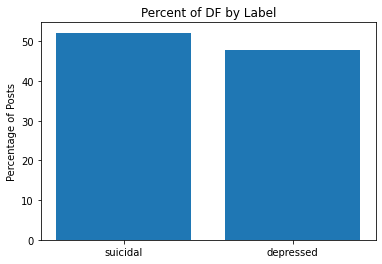

In [163]:
x = ['suicidal','depressed']
y = [round((len(depression_full[depression_full['suicidal']==1])/len(depression_full)*100),2),round((len(depression_full[depression_full['suicidal']==0])/len(depression_full)*100),2)]
plt.ylabel('Percentage of Posts')
plt.title('Percent of DF by Label')
plt.bar(x,y)
plt.show()

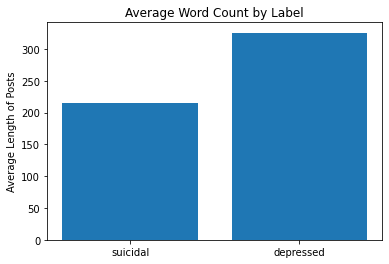

In [164]:
x = ['suicidal','depressed']
y = [depression_full[depression_full['suicidal']==1]['word_count'].mean(),depression_full[depression_full['suicidal']==0]['word_count'].mean()]
plt.ylabel('Average Length of Posts')
plt.title('Average Word Count by Label')
plt.bar(x,y)
plt.show()

In [165]:
depression_full.head()

,text,posts,date_posted,username,word_count,readability_score,SPACE__SP,AUX_VBP,PRON_PRP,ADV_RB,VERB_VB,SCONJ_IN,PRON_NN,AUX_VBZ,VERB_VBG,PUNCT_.,CCONJ_CC,VERB_VBP,PART_TO,PRON_WP,AUX_MD,AUX_VB,ADP_IN,PRON_PRP$,NOUN_NN,ADJ_JJ,PROPN_NNP,NOUN_NNS,ADP_RP,"PUNCT_,",VERB_VBN,PUNCT_``,NUM_CD,PART_RB,DET_DT,SCONJ_WRB,VERB_VBZ,AUX_VBD,PRON_EX,VERB_VBD,PUNCT_:,PUNCT_'',PUNCT_HYPH,ADJ_JJS,PRON_WDT,PRON_DT,PUNCT_-LRB-,PUNCT_-RRB-,PART_POS,X_LS,ADJ_JJR,ADV_RBR,PUNCT_NFP,INTJ_UH,DET_PDT,AUX_VBG,ADV_RBS,X_XX,X_ADD,SYM_SYM,AUX_VBN,DET_WDT,AUX_RB,X_FW,SYM_$,DET_WP$,PROPN_NNPS,AUX_UH,AUX_IN,AUX_POS,ADJ_AFX,AUX_NN,AUX_NNP,VERB_NNP,AUX_NFP,AUX_``,AUX_FW,VERB_MD,AUX_'',VERB_NN,AUX_SYM,AUX_RBR,VERB_POS,AUX_NNS,AUX_CD,AUX_JJ,AUX_ADD,AUX_:,AUX_-LRB-,VERB_NNS,AUX_HYPH,AUX_PRP,ADV_CC,AUX_.,AUX_XX,AUX_WRB,clean_text,suicidal
0,\n\n\nDo you ever feel like everyone is watchi...,8,2022-07-19,ayoubalharchal,400,82.616667,4.76,2.75,11.36,3.66,6.59,3.30,0.55,1.28,3.48,7.88,1.47,3.66,2.56,1.28,1.65,1.10,4.76,1.47,6.59,4.58,1.65,3.30,0.92,2.56,0.73,2.01,1.47,0.73,3.48,1.65,0.92,0.55,0.18,0.73,0.37,1.65,0.18,0.18,0.37,0.37,0.18,0.18,0.18,0.18,0.18,0.18,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ever feel like everyone watch start overthink ...,0
1,\n\n\nDo you compare yourself to other people ...,8,2022-07-14,ayoubalharchal,427,64.490101,5.91,1.39,10.43,5.22,6.78,2.96,2.09,1.04,2.61,7.30,2.96,4.87,2.78,0.52,2.26,0.87,6.26,1.04,5.91,5.22,0.17,3.30,0.35,4.70,0.87,0.35,1.22,0.70,3.48,1.04,1.57,0.35,NaN,0.35,0.35,0.35,NaN,0.17,0.17,0.70,NaN,NaN,NaN,NaN,0.17,0.87,0.17,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,compare people hate make feel like you re enou...,0
2,\n\n\nDo you find yourself apologizing all the...,8,2022-07-14,ayoubalharchal,379,77.653752,5.11,2.46,10.80,3.60,6.06,0.76,0.38,1.14,1.70,7.20,3.60,3.79,1.33,0.38,1.70,0.38,5.87,2.65,8.71,4.17,2.46,4.73,NaN,4.17,0.19,0.57,1.14,1.89,3.98,1.52,0.95,NaN,NaN,0.19,0.38,0.57,1.14,0.19,0.76,0.76,NaN,NaN,0.19,NaN,0.19,0.19,0.76,0.19,0.38,0.19,0.19,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,find apologize time even thing be not really f...,0
3,"\n\n\nIF SO, READING & UNDERSTANDING THIS WILL...",8,2022-07-12,ayoubalharchal,377,74.071391,5.59,1.12,6.15,3.35,3.35,1.68,0.37,1.30,2.05,5.96,4.84,3.72,1.30,0.37,1.86,1.12,5.03,1.49,10.80,6.89,1.49,2.42,0.19,3.91,1.49,1.68,2.42,0.93,6.89,0.74,0.37,1.30,0.37,0.56,0.74,1.49,0.74,NaN,NaN,1.30,0.56,0.56,NaN,NaN,0.37,0.19,NaN,0.19,0.37,NaN,NaN,NaN,0.19,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,read understand free soul today ill talk anoth...,0
4,\n\n\nAren’t you a little bit tired of people ...,8,2022-07-12,ayoubalharchal,467,79.586657,4.57,1.47,8.65,5.22,7.01,1.96,0.49,0.33,1.31,6.04,3.26,4.57,2.45,0.49,1.96,0.49,6.36,2.28,8.16,5.55,0.82,4.40,0.65,3.43,1.31,1.47,1.47,0.98,4.08,1.14,0.82,0.49,0.49,0.98,0.49,1.14,0.33,NaN,0.82,0.65,0.16,0.16,NaN,NaN,0.16,NaN,0.16,0.33,0.16,NaN,NaN,NaN,0.16,NaN,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,be not little bit tired people tell think posi...,0


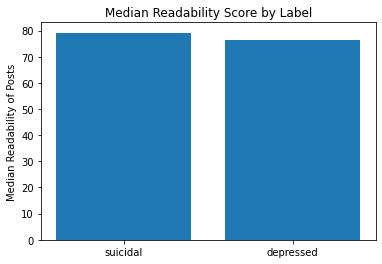

In [166]:
x = ['suicidal','depressed']
y = [depression_full[depression_full['suicidal']==1]['readability_score'].median(),depression_full[depression_full['suicidal']==0]['readability_score'].median()]
plt.ylabel('Median Readability of Posts')
plt.title('Median Readability Score by Label')
plt.bar(x,y)
plt.show()

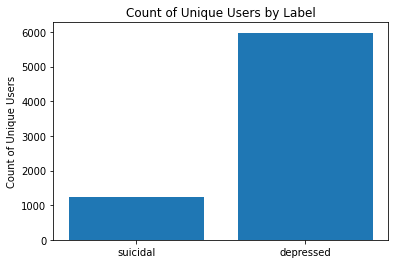

In [167]:
x = ['suicidal','depressed']
y = [len(depression_full[depression_full['suicidal']==1]['username'].unique()),len(depression_full[depression_full['suicidal']==0]['username'].unique())]
plt.ylabel('Count of Unique Users')
plt.title('Count of Unique Users by Label')
plt.bar(x,y)
plt.show()

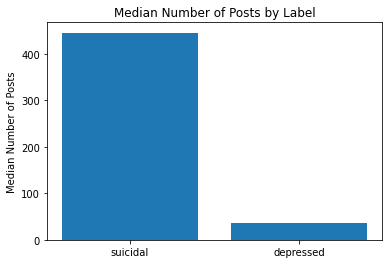

In [168]:
x = ['suicidal','depressed']
y = [pd.DataFrame(depression_full[depression_full['suicidal']==1].groupby('username')['posts'].max()).sort_values('posts')['posts'].mean(),pd.DataFrame(depression_full[depression_full['suicidal']==0].groupby('username')['posts'].max()).sort_values('posts')['posts'].mean()]
plt.ylabel('Median Number of Posts')
plt.title('Median Number of Posts by Label')
plt.bar(x,y)
plt.show()

In [169]:
depression_date = depression_full.copy()
depression_date["date_posted"] = depression_date["date_posted"].astype("datetime64")
depression_date = depression_date.set_index("date_posted")

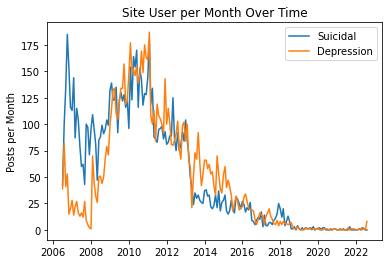

In [170]:
x = depression_date[depression_date['suicidal']==0].groupby(pd.Grouper(freq='M')).count().index
y_s =  depression_date[depression_date['suicidal']==1].groupby(pd.Grouper(freq='M')).count()['posts'] 
y_s['2022-06-30'] = 0
y_s['2022-07-31'] = 0
y_d =  depression_date[depression_date['suicidal']==0].groupby(pd.Grouper(freq='M')).count()['posts']
plt.plot(x, y_s, label = "Suicidal")
plt.plot(x, y_d, label = "Depression")
plt.ylabel('Posts per Month')
plt.title('Site User per Month Over Time')
plt.legend()
plt.show()

In [171]:
depression_full.drop(columns=['readability_score'],inplace=True)

In [172]:
depression_full.dropna(subset=['username','text','clean_text'],inplace=True)

In [173]:
depression_full.head()

,text,posts,date_posted,username,word_count,SPACE__SP,AUX_VBP,PRON_PRP,ADV_RB,VERB_VB,SCONJ_IN,PRON_NN,AUX_VBZ,VERB_VBG,PUNCT_.,CCONJ_CC,VERB_VBP,PART_TO,PRON_WP,AUX_MD,AUX_VB,ADP_IN,PRON_PRP$,NOUN_NN,ADJ_JJ,PROPN_NNP,NOUN_NNS,ADP_RP,"PUNCT_,",VERB_VBN,PUNCT_``,NUM_CD,PART_RB,DET_DT,SCONJ_WRB,VERB_VBZ,AUX_VBD,PRON_EX,VERB_VBD,PUNCT_:,PUNCT_'',PUNCT_HYPH,ADJ_JJS,PRON_WDT,PRON_DT,PUNCT_-LRB-,PUNCT_-RRB-,PART_POS,X_LS,ADJ_JJR,ADV_RBR,PUNCT_NFP,INTJ_UH,DET_PDT,AUX_VBG,ADV_RBS,X_XX,X_ADD,SYM_SYM,AUX_VBN,DET_WDT,AUX_RB,X_FW,SYM_$,DET_WP$,PROPN_NNPS,AUX_UH,AUX_IN,AUX_POS,ADJ_AFX,AUX_NN,AUX_NNP,VERB_NNP,AUX_NFP,AUX_``,AUX_FW,VERB_MD,AUX_'',VERB_NN,AUX_SYM,AUX_RBR,VERB_POS,AUX_NNS,AUX_CD,AUX_JJ,AUX_ADD,AUX_:,AUX_-LRB-,VERB_NNS,AUX_HYPH,AUX_PRP,ADV_CC,AUX_.,AUX_XX,AUX_WRB,clean_text,suicidal
0,\n\n\nDo you ever feel like everyone is watchi...,8,2022-07-19,ayoubalharchal,400,4.76,2.75,11.36,3.66,6.59,3.30,0.55,1.28,3.48,7.88,1.47,3.66,2.56,1.28,1.65,1.10,4.76,1.47,6.59,4.58,1.65,3.30,0.92,2.56,0.73,2.01,1.47,0.73,3.48,1.65,0.92,0.55,0.18,0.73,0.37,1.65,0.18,0.18,0.37,0.37,0.18,0.18,0.18,0.18,0.18,0.18,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ever feel like everyone watch start overthink ...,0
1,\n\n\nDo you compare yourself to other people ...,8,2022-07-14,ayoubalharchal,427,5.91,1.39,10.43,5.22,6.78,2.96,2.09,1.04,2.61,7.30,2.96,4.87,2.78,0.52,2.26,0.87,6.26,1.04,5.91,5.22,0.17,3.30,0.35,4.70,0.87,0.35,1.22,0.70,3.48,1.04,1.57,0.35,NaN,0.35,0.35,0.35,NaN,0.17,0.17,0.70,NaN,NaN,NaN,NaN,0.17,0.87,0.17,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,compare people hate make feel like you re enou...,0
2,\n\n\nDo you find yourself apologizing all the...,8,2022-07-14,ayoubalharchal,379,5.11,2.46,10.80,3.60,6.06,0.76,0.38,1.14,1.70,7.20,3.60,3.79,1.33,0.38,1.70,0.38,5.87,2.65,8.71,4.17,2.46,4.73,NaN,4.17,0.19,0.57,1.14,1.89,3.98,1.52,0.95,NaN,NaN,0.19,0.38,0.57,1.14,0.19,0.76,0.76,NaN,NaN,0.19,NaN,0.19,0.19,0.76,0.19,0.38,0.19,0.19,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,find apologize time even thing be not really f...,0
3,"\n\n\nIF SO, READING & UNDERSTANDING THIS WILL...",8,2022-07-12,ayoubalharchal,377,5.59,1.12,6.15,3.35,3.35,1.68,0.37,1.30,2.05,5.96,4.84,3.72,1.30,0.37,1.86,1.12,5.03,1.49,10.80,6.89,1.49,2.42,0.19,3.91,1.49,1.68,2.42,0.93,6.89,0.74,0.37,1.30,0.37,0.56,0.74,1.49,0.74,NaN,NaN,1.30,0.56,0.56,NaN,NaN,0.37,0.19,NaN,0.19,0.37,NaN,NaN,NaN,0.19,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,read understand free soul today ill talk anoth...,0
4,\n\n\nAren’t you a little bit tired of people ...,8,2022-07-12,ayoubalharchal,467,4.57,1.47,8.65,5.22,7.01,1.96,0.49,0.33,1.31,6.04,3.26,4.57,2.45,0.49,1.96,0.49,6.36,2.28,8.16,5.55,0.82,4.40,0.65,3.43,1.31,1.47,1.47,0.98,4.08,1.14,0.82,0.49,0.49,0.98,0.49,1.14,0.33,NaN,0.82,0.65,0.16,0.16,NaN,NaN,0.16,NaN,0.16,0.33,0.16,NaN,NaN,NaN,0.16,NaN,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,be not little bit tired people tell think posi...,0


In [174]:
depression_full.isna().sum()

text               0
posts              0
date_posted        0
username           0
word_count         0
               ...  
AUX_.          19149
AUX_XX         19141
AUX_WRB        19148
clean_text         0
suicidal           0
Length: 97, dtype: int64

In [175]:
depression_full['date_posted'] = [datetime.datetime.strptime(datetime_str, '%Y-%m-%d') for datetime_str in depression_full['date_posted']]

In [176]:
depression_full['day_of_week'] = [date.isoweekday() for date in depression_full['date_posted']]

In [178]:
depression_full['text'] = depression_full['text'].apply(lambda x:cleanText(x,remove_stop=False))

In [184]:
depression_full['text'] = depression_full['text'].apply(lambda x:  " ".join(x.split()))

In [186]:
depression_full.drop(columns=['date_posted','clean_text'],inplace=True)

In [187]:
depression_full = depression_full.fillna(0)

In [188]:
depression_full.head()

,text,posts,username,word_count,SPACE__SP,AUX_VBP,PRON_PRP,ADV_RB,VERB_VB,SCONJ_IN,PRON_NN,AUX_VBZ,VERB_VBG,PUNCT_.,CCONJ_CC,VERB_VBP,PART_TO,PRON_WP,AUX_MD,AUX_VB,ADP_IN,PRON_PRP$,NOUN_NN,ADJ_JJ,PROPN_NNP,NOUN_NNS,ADP_RP,"PUNCT_,",VERB_VBN,PUNCT_``,NUM_CD,PART_RB,DET_DT,SCONJ_WRB,VERB_VBZ,AUX_VBD,PRON_EX,VERB_VBD,PUNCT_:,PUNCT_'',PUNCT_HYPH,ADJ_JJS,PRON_WDT,PRON_DT,PUNCT_-LRB-,PUNCT_-RRB-,PART_POS,X_LS,ADJ_JJR,ADV_RBR,PUNCT_NFP,INTJ_UH,DET_PDT,AUX_VBG,ADV_RBS,X_XX,X_ADD,SYM_SYM,AUX_VBN,DET_WDT,AUX_RB,X_FW,SYM_$,DET_WP$,PROPN_NNPS,AUX_UH,AUX_IN,AUX_POS,ADJ_AFX,AUX_NN,AUX_NNP,VERB_NNP,AUX_NFP,AUX_``,AUX_FW,VERB_MD,AUX_'',VERB_NN,AUX_SYM,AUX_RBR,VERB_POS,AUX_NNS,AUX_CD,AUX_JJ,AUX_ADD,AUX_:,AUX_-LRB-,VERB_NNS,AUX_HYPH,AUX_PRP,ADV_CC,AUX_.,AUX_XX,AUX_WRB,suicidal,day_of_week
0,do you ever feel like everyone is watching you...,8,ayoubalharchal,400,4.76,2.75,11.36,3.66,6.59,3.30,0.55,1.28,3.48,7.88,1.47,3.66,2.56,1.28,1.65,1.10,4.76,1.47,6.59,4.58,1.65,3.30,0.92,2.56,0.73,2.01,1.47,0.73,3.48,1.65,0.92,0.55,0.18,0.73,0.37,1.65,0.18,0.18,0.37,0.37,0.18,0.18,0.18,0.18,0.18,0.18,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2
1,do you compare yourself to other people and ha...,8,ayoubalharchal,427,5.91,1.39,10.43,5.22,6.78,2.96,2.09,1.04,2.61,7.30,2.96,4.87,2.78,0.52,2.26,0.87,6.26,1.04,5.91,5.22,0.17,3.30,0.35,4.70,0.87,0.35,1.22,0.70,3.48,1.04,1.57,0.35,0.00,0.35,0.35,0.35,0.00,0.17,0.17,0.70,0.00,0.00,0.00,0.00,0.17,0.87,0.17,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4
2,do you find yourself apologizing all the time ...,8,ayoubalharchal,379,5.11,2.46,10.80,3.60,6.06,0.76,0.38,1.14,1.70,7.20,3.60,3.79,1.33,0.38,1.70,0.38,5.87,2.65,8.71,4.17,2.46,4.73,0.00,4.17,0.19,0.57,1.14,1.89,3.98,1.52,0.95,0.00,0.00,0.19,0.38,0.57,1.14,0.19,0.76,0.76,0.00,0.00,0.19,0.00,0.19,0.19,0.76,0.19,0.38,0.19,0.19,0.38,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4
3,if so reading understanding this will free you...,8,ayoubalharchal,377,5.59,1.12,6.15,3.35,3.35,1.68,0.37,1.30,2.05,5.96,4.84,3.72,1.30,0.37,1.86,1.12,5.03,1.49,10.80,6.89,1.49,2.42,0.19,3.91,1.49,1.68,2.42,0.93,6.89,0.74,0.37,1.30,0.37,0.56,0.74,1.49,0.74,0.00,0.00,1.30,0.56,0.56,0.00,0.00,0.37,0.19,0.00,0.19,0.37,0.00,0.00,0.00,0.19,0.19,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2
4,aren’t you a little bit tired of people tellin...,8,ayoubalharchal,467,4.57,1.47,8.65,5.22,7.01,1.96,0.49,0.33,1.31,6.04,3.26,4.57,2.45,0.49,1.96,0.49,6.36,2.28,8.16,5.55,0.82,4.40,0.65,3.43,1.31,1.47,1.47,0.98,4.08,1.14,0.82,0.49,0.49,0.98,0.49,1.14,0.33,0.00,0.82,0.65,0.16,0.16,0.00,0.00,0.16,0.00,0.16,0.33,0.16,0.00,0.00,0.00,0.16,0.00,0.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2


In [189]:
depression_full.isna().sum()

text           0
posts          0
username       0
word_count     0
SPACE__SP      0
              ..
AUX_.          0
AUX_XX         0
AUX_WRB        0
suicidal       0
day_of_week    0
Length: 96, dtype: int64

In [190]:
depression_full.to_csv('modeling_with_stopwords.csv',index=None)